### Import

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import matplotlib.image as mpimg
import os
from itertools import product

from load_atoms import load_dataset

# Полностью отключить все предупреждения
warnings.filterwarnings("ignore")

In [22]:
plt.rcParams['font.family'] = 'serif'

### Si 3D amorphous data

In [23]:
coords = np.array([
    [0.00, 0.00, 0.00],
    [0.25, 0.25, 0.25],
    [0.50, 0.00, 0.50],
    [0.00, 0.50, 0.50],
    [0.50, 0.50, 0.00],
    [0.75, 0.25, 0.75],
    [0.25, 0.75, 0.75],
    [0.75, 0.75, 0.25],
])

x, y, z = coords.T

In [24]:
dataset = load_dataset("a-Si-24")

Output()

In [25]:
atoms = dataset[1582]

atoms.info['label']

'216_atoms/10^13/run_nvt_Si216_2.500_1/npt-anneal_293K_10ps'

In [26]:
def get_info(atoms):
    cell_size = atoms.cell[0][0]
    structure_energy = round(atoms.info['energy'])
    
    np.max(atoms.arrays['forces'])
    
    print("cell size:", round(cell_size, 3), "energy of unit cell:", structure_energy)
    
    atoms_positions = atoms.arrays['positions']/cell_size
    
    atoms_data = []
    
    for position in atoms_positions:
        atoms_data.append(f"  'Si'    {position[0]:.3f}    {position[1]:.3f}    {position[2]:.3f}    1")
    
    atoms_data.append('')
    
    print(int(atoms.info['label'].split('_')[0]))

In [27]:
cell_size = atoms.cell[0][0]
atoms.arrays['positions'][:5]/cell_size

array([[0.81976114, 0.66558743, 0.15629867],
       [0.28780303, 0.58957784, 0.40681323],
       [0.15882645, 0.29229502, 0.67315722],
       [0.43856694, 0.76871893, 0.36219826],
       [0.680881  , 0.54014814, 0.72458131]])

In [28]:
int(atoms.info['label'].split('_')[0])

216

In [29]:
atoms.info['label']

'216_atoms/10^13/run_nvt_Si216_2.500_1/npt-anneal_293K_10ps'

### Histogram

In [8]:
from ase.build import bulk
from ase.io import write
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from dscribe.descriptors import SOAP
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 1️⃣ Генерация кристаллического кремния
# --------------------------
cryst = bulk("Si", "diamond", a=5.43)

# --------------------------
# 2️⃣ Генерация аморфного кремния (условно)
# --------------------------
# Для демонстрации: слегка "расплавим" кристалл, добавим шум
amorph = cryst.copy()
rng = np.random.default_rng(42)
amorph.positions += rng.normal(0, 0.5, size=amorph.positions.shape)  # добавляем случайное смещение

# --------------------------
# 3️⃣ Настройка SOAP-дескриптора
# --------------------------
soap = SOAP(
    species=["Si"],
    periodic=True,
    r_cut=6,   # радиус усечения (Å)
    n_max=16,     # радиальные базисы
    l_max=16,     # максимальный орбитальный момент
    sigma=0.2   # сглаживание (Å)
)

# --------------------------
# 4️⃣ Вычисляем SOAP для обеих структур
# --------------------------
soap_cryst = soap.create(cryst)
soap_amorph = soap.create(amorph)

print("SOAP shapes:")
print("crystalline:", soap_cryst.shape)
print("amorphous:", soap_amorph.shape)

# --------------------------
# 5️⃣ Сравниваем с кристаллическим эталоном
# --------------------------
# Возьмём средний SOAP-вектор для идеального кристалла
ref = np.mean(soap_cryst, axis=0).reshape(1, -1)

# Косинусное сходство каждого атома с эталоном
sim_cryst = cosine_similarity(soap_cryst, ref).flatten()
sim_amorph = cosine_similarity(soap_amorph, ref).flatten()

# --------------------------
# 6️⃣ Визуализация
# --------------------------
# plt.figure(figsize=(7,5))
# plt.hist(sim_cryst, bins=20, alpha=0.7, label="crystalline Si", color='blue')
# plt.hist(sim_amorph, bins=20, alpha=0.7, label="amorphous Si (simulated)", color='orange')
# plt.xlabel("SOAP similarity to crystalline reference")
# plt.ylabel("Number of atoms")
# plt.title("Local Structural Similarity (SOAP kernel)")
# plt.legend()
# plt.show()


SOAP shapes:
crystalline: (2, 2312)
amorphous: (2, 2312)


In [20]:
soap_vals = []

for j in range(801, 1580, 1):

    atoms = dataset[j]
    
    soap_amorph = soap.create(atoms)
    sim = np.mean(cosine_similarity(soap_amorph, ref).flatten())
    soap_vals.append(sim)
    # print(sim)

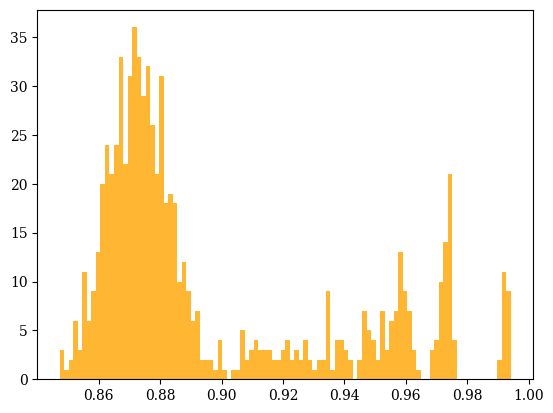

In [22]:
plt.hist(soap_vals, bins=100, alpha=0.8, label="amorphous Si (simulated)", color='orange')
plt.show()

In [625]:
min(soap_vals)

np.float64(0.8376576293474388)

In [626]:
max(soap_vals)

np.float64(0.9949311611681378)

### Choosing structures

In [628]:
# atoms = dataset[899]
# cut_size = 11.107
# coords = atoms.positions
# mask = np.all(coords < cut_size, axis=1)
# filtered_atoms = atoms[mask]
# print(len(filtered_atoms))

# filtered_atoms.cell = [cut_size, cut_size, cut_size]

# soap_amorph = soap.create(filtered_atoms)
# sim = np.mean(cosine_similarity(soap_amorph, ref).flatten())
# print(sim)
# soap_amorph = soap.create(atoms)
# sim2 = np.mean(cosine_similarity(soap_amorph, ref).flatten())
# print(sim2)

In [57]:
atoms = dataset[852]
    
soap_amorph = soap.create(atoms)
np.mean(cosine_similarity(soap_amorph, ref).flatten())

np.float64(0.9200631687092411)

In [23]:
soap_vals_arr = np.array(soap_vals)

In [55]:
soap_mask = (soap_vals_arr > 0.919) & (soap_vals_arr < 0.921)

print(np.where(soap_mask))

soap_vals_arr[soap_mask]

(array([ 51, 100, 297, 310, 348]),)


array([0.92006317, 0.92095379, 0.91920878, 0.92048672, 0.91971835])

In [463]:
800+np.where(soap_mask)[0]

array([837, 856, 857, 865, 870, 872, 877, 878, 879, 880, 882, 884, 885,
       886, 893, 895, 898, 899])

### Func for generating input files

In [30]:
def create_cell(nx_max, ny_max, nz_max, dev): 
    
    atoms_data = []
    
    for nx, ny, nz in np.ndindex(nx_max, ny_max, nz_max):
        for i in range(8):
            
            rx, ry, rz = np.clip(np.random.normal(0, dev, 3),-2*dev ,2*dev)
    
            xval = x[i]/nx_max + nx/nx_max
            yval = y[i]/ny_max + ny/ny_max
            zval = z[i]/nz_max + nz/nz_max

            if xval>0 and xval<1:
                if 0 < xval+rx < 1:
                    xval+=(rx/nx_max)

            if yval>0 and yval<1:
                if 0 < yval+ry < 1:
                    yval+=(ry/ny_max)

            if zval>0 and zval<1:
                if 0 < zval+rz < 1:
                    zval+=(rz/nz_max)
        
            atoms_data.append(f"  'Si'    {xval:.3f}    {yval:.3f}    {zval:.3f}    1") 
        
        atoms_data.append('')
    

    return atoms_data

In [31]:
# generate_input_files('gs', 2, 1, 2, 0, 12, 2, 1, 500, 9)

In [32]:
# c - cell, s - sigma, i - number of max iterations, t - threshold of convergence, a - factor for number of states,
# r and k -- nums for r- and k- grids for 8 atoms in the cell
# input_types: 'gs', 'pulse', 'weak_pulse', 'response'

In [33]:
def generate_input_files(input_type, nx_max, ny_max, nz_max, dev, num_r, num_k, a, num_it, num_thr, atoms, j, sim, I_probe):
    
        
    # atoms_data = create_cell(nx_max, ny_max, nz_max, dev)

    if 8*nx_max*ny_max*nz_max != int(atoms.info['label'].split('_')[0]):
        raise ValueError("Количество атомов в dataset[j] не соответствует размеру ячейки")
    
    cell_size = atoms.cell[0][0]+0.1
    structure_energy = round(-atoms.info['energy'])    
    atoms_positions = atoms.arrays['positions']/cell_size
    
    atoms_data = []
    
    for position in atoms_positions:
        atoms_data.append(f"  'Si'    {position[0]:.3f}    {position[1]:.3f}    {position[2]:.3f}    1")
    
    atoms_data.append('')
    
    
    if input_type == 'gs':
        with open('base_inputs/Si_gs.inp', 'r') as file:
            lines = file.readlines()
    
    
    if input_type == 'both_pulses' or input_type == 'probe_pulse' or input_type == 'pump_pulse':
        with open('base_inputs/Si_rt_pulse.inp', 'r') as file:
            lines = file.readlines()
    
    
    if input_type == 'response':
        with open('base_inputs/Si_rt_response.inp', 'r') as file:
            lines = file.readlines()
    
    
            
    # if input_type == 'gs' or input_type == 'pulse':
    #     # Заменяем строку для названия output файлов
    #     for i, line in enumerate(lines):
    #         if 'sysname' in line:
    #             lines[i] = f"  sysname = 'Si_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}'\n"
    
    
    # if input_type == 'weak_pulse':
    #     # Заменяем строку для названия output файлов
    #     for i, line in enumerate(lines):
    #         if 'sysname' in line:
    #             lines[i] = f"  sysname = 'Si_weak_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}'\n"


    if input_type == 'pump_pulse':
        # Заменяем строку для названия output файлов
        for i, line in enumerate(lines):
            if 'sysname' in line:
                lines[i] = f"  sysname = 'pump_pulse'\n"

    if input_type == 'probe_pulse':
        # Заменяем строку для названия output файлов
        for i, line in enumerate(lines):
            if 'sysname' in line:
                lines[i] = f"  sysname = 'probe_pulse'\n"

    
    # if input_type == 'response':
    #     # Заменяем строку для названия output файлов
    #     for i, line in enumerate(lines):
    #         if 'sysname' in line:
    #             lines[i] = f"  sysname = 'Si_response_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}'\n"
        
    
    # Заменяем строку для al(1:3)
    for i, line in enumerate(lines):
        if 'al(1:3)' in line:
            lines[i] = f"  al(1:3) = {cell_size:.2f}d0, {cell_size:.2f}d0, {cell_size:.2f}d0\n"
    
    # Заменяем строку для num_rgrid(1:3)
    for i, line in enumerate(lines):
        if 'num_rgrid(1:3)' in line:
            lines[i] = f"  num_rgrid(1:3) = {nx_max*num_r:.0f}, {ny_max*num_r:.0f}, {nz_max*num_r:.0f}\n"
    
    # Заменяем строку для num_kgrid(1:3)
    for i, line in enumerate(lines):
        if 'num_kgrid(1:3)' in line:
            lines[i] = f"  num_kgrid(1:3) = {num_k/nx_max:.0f}, {num_k/ny_max:.0f}, {num_k/nz_max:.0f}\n"

    # # Заменяем строку для num_kgrid(1:3)
    # for i, line in enumerate(lines):
    #     if 'num_kgrid(1:3)' in line:
    #         lines[i] = f"  num_kgrid(1:3) = {num_k:.0f}, {num_k:.0f}, {num_k:.0f}\n"
    
    
    start_idx = None
    end_idx = None
    
    # Находим места начала и конца для замены количества атомов и электронов
    for i, line in enumerate(lines):
        if 'nelem  =' in line:
            start_idx = i
        if '/' in line and start_idx is not None:
            end_idx = i
            break
    
    
    n_data = [f"  natom  = {8*nx_max*ny_max*nz_max:.0f}", f"  nelec  = {32*nx_max*ny_max*nz_max:.0f}", f"  nstate = {a*32*nx_max*ny_max*nz_max:.0f}"]
    
    # Заменяем блок координат
    lines[start_idx + 1:end_idx] = [line + '\n' for line in n_data]
    
    
    # Заменяем старые координаты атомов новыми
    start_idx = None
    end_idx = None
    
    # Находим места начала и конца для замены атомных координат
    for i, line in enumerate(lines):
        if '&atomic_red_coor' in line:
            start_idx = i
        if '!--- Format' in line and start_idx is not None:
            end_idx = i
            break
    
    # Заменяем блок координат
    lines[start_idx + 1:end_idx] = [line + '\n' for line in atoms_data]
    
    
    if input_type == 'pump_pulse':
        # Заменяем мощность
        for i, line in enumerate(lines):
            if 'I_wcm2_1 =' in line:
                lines[i] = "  I_wcm2_1 = 0d9\n"


    if input_type == 'probe_pulse':
        # Заменяем мощность
        for i, line in enumerate(lines):
            if 'I_wcm2_2 =' in line:
                lines[i] = "  I_wcm2_2 = 0d12\n"
    
    
    if input_type == 'gs':
        # Заменяем строку для nscf
        for i, line in enumerate(lines):
            if 'nscf' in line:
                lines[i] = f"  nscf      = {num_it:.0f}\n"
        
        # Заменяем строку для threshold
        for i, line in enumerate(lines):
            if 'threshold =' in line:
                lines[i] = f"  threshold = 1.0d-{num_thr:.0f}\n"
    
    fold_name = f"c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}_p{I_probe}_load_№{j}_amorphous_{sim:.3f}"
    
    if input_type == 'gs':
        os.mkdir("generated/"+fold_name)
    
    if input_type == 'gs':
        # Сохраняем изменения в файл
        with open("generated/" + fold_name + f"/Si_gs_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
            file.writelines(lines)
    
    if input_type == 'both_pulses':
        # Сохраняем изменения в файл
        with open("generated/" + fold_name + f"/Si_rt_both_pulses_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
            file.writelines(lines)
    
    if input_type == 'pump_pulse':
        # Сохраняем изменения в файл
        with open("generated/" + fold_name + f"/Si_rt_pump_pulse_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
            file.writelines(lines)

    if input_type == 'probe_pulse':
        # Сохраняем изменения в файл
        with open("generated/" + fold_name + f"/Si_rt_probe_pulse_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
            file.writelines(lines)
    
    if input_type == 'response':
        # Сохраняем изменения в файл
        with open("generated/" + fold_name + f"/Si_response_rt_pulse_c{nx_max}{ny_max}{nz_max}_s{5.43*dev:.2f}_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
            file.writelines(lines)

In [34]:
devs = np.linspace(0.009209*5.43, 2*0.009209*5.43, 2)
devs

np.linspace(0*0.009209*5.43, 0*0.009209*5.43, 1)

array([0.])

In [35]:
# atoms = dataset[852]
    
# soap_amorph = soap.create(atoms)
# np.mean(cosine_similarity(soap_amorph, ref).flatten())

In [82]:
devs = np.linspace(0*0.009209, 0*0.009209, 1)
ns = [(3, 3, 3)]
num_rs = [18]
num_ks = [16]
a_s = [1]
n_it = 800
I_probe_pump = "3d10_5d11"

j_sim_s = [(856, 0.992), (1162, 0.976), (941, 0.961), (1142, 0.95), (854, 0.94), (889, 0.93), (852, 0.92)]


for (nx, ny, nz), dev_val, r, k, a, (j, sim) in product(ns, devs, num_rs, num_ks, a_s, j_sim_s):

    atoms = dataset[j]
    
    # atoms_data = create_cell(nx, ny, nz, dev_val)
    
    generate_input_files('gs', nx, ny, nz, dev_val, r, k, a, n_it, 9, atoms, j, sim, I_probe_pump)
    generate_input_files('both_pulses', nx, ny, nz, dev_val, r, k, a, n_it, 9, atoms, j, sim, I_probe_pump)
    generate_input_files('pump_pulse', nx, ny, nz, dev_val, r, k, a, n_it, 9, atoms, j, sim,  I_probe_pump)
    generate_input_files('probe_pulse', nx, ny, nz, dev_val, r, k, a, n_it, 9, atoms, j, sim, I_probe_pump)
    # generate_input_files('response', nx, ny, nz, dev_val, r, k, a, n_it, 9, atoms)

In [62]:
devs = np.linspace(0.01, 0.01, 1)
devs

array([0.01])

In [63]:
print(f"{2.8:.0f}")

3


In [202]:
# нужно чтобы четность N/s совпадала с четностью N!

def monchorst(N, s):

    primitive = [round((2*x - N - 1)/(2*N), 2) for x in range(1, N+1)]
    print('N =', N, '  s =', s, '  N/s = ', float(N/s))
    print('primitive: ', primitive)

    super_cell = [round((2*x - (N/s) - 1)/(2*N/s)/s, 2) for x in range(1, int(N/s)+1)]
    print('super cell: ', super_cell)
    print(' ')

In [204]:
# [(monchorst(2*j, j), monchorst(3*j, j), monchorst(4*j, j), monchorst(5*j, j)) for j in range(2, 3)]

### Plots for generated

In [282]:
part_name = f"c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}"
print(part_name)

c121_s0_r12_k2_a1_i1000_t9


In [115]:
def plot_response_generated(folder, ax, part_name):
    
    # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data = pd.read_csv(
        folder + '/Si_' + part_name + '_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    # Назначим читаемые имена колонкам
    data.columns = [
        'time_fs',         # 1
        'Ac_ext_x',        # 2
        'Ac_ext_y',        # 3
        'Ac_ext_z',        # 4
        'E_ext_x',         # 5
        'E_ext_y',         # 6
        'E_ext_z',         # 7
        'Ac_tot_x',        # 8
        'Ac_tot_y',        # 9
        'Ac_tot_z',        #10
        'E_tot_x',         #11
        'E_tot_y',         #12
        'E_tot_z',         #13
        'Jm_x',         #14
        'Jm_y',         #15
        'Jm_z',         #16
    ]
    
    
    # 1:Time[fs] 2:Ac_ext_x[fs*V/Angstrom] 3:Ac_ext_y[fs*V/Angstrom] 4:Ac_ext_z[fs*V/Angstrom]
    #5:E_ext_x[V/Angstrom] 6:E_ext_y[V/Angstrom] 7:E_ext_z[V/Angstrom] 8:Ac_tot_x[fs*V/Angstrom]
    # 9:Ac_tot_y[fs*V/Angstrom] 10:Ac_tot_z[fs*V/Angstrom] 11:E_tot_x[V/Angstrom]
    # 12:E_tot_y[V/Angstrom] 13:E_tot_z[V/Angstrom]  14:Jm_x[1/fs*Angstrom^2] 15:Jm_y[1/fs*Angstrom^2] 16:Jm_z[1/fs*Angstrom^2]
    
    
    # Построим графики
    plt.figure(figsize=(10, 5))

    # Общий заголовок для всей фигуры
    plt.suptitle(' '.join(re.split('[/_]', folder)), fontsize=14)
    
    # Первый график: внешнее поле по z
    plt.subplot(2, 2, 1)
    plt.plot(data['time_fs'], data['E_ext_z'], label='E_ext_z', color='blue')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [V/Å]')
    plt.title('External electric field z')
    plt.grid(True)
    #plt.legend()
    
    # Второй график: дипольный момент по z
    plt.subplot(2, 2, 4)
    plt.plot(data['time_fs'], data['Jm_'+ax], label='Dipole Moment z', color='magenta')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \cdot Å^{-2}$]')
    plt.title('Full matter current density')
    plt.grid(True)
    #plt.legend()
    
    plt.tight_layout()
    
    # Загрузка данных с указанием имен столбцов
    energy_data = pd.read_csv(
        folder + '/Si_' + part_name + '_rt_energy.data',
        comment='#',
        delim_whitespace=True,
        header=None,
        names=['Time_fs', 'E_total_eV', 'Delta_E_eV']
    )
    
    # Построение графика изменения энергии во времени
    plt.subplot(2, 2, 3)
    plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Full excitation energy per unit cell')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    
    # Загрузка данных с указанием имен столбцов
    data = pd.read_csv(
        folder + '/Si_' + part_name + '_pulse.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    # Назначим читаемые имена колонкам
    data.columns = [
        'energy_eV',           # 1
        'Re_Jm_x',             # 2
        'Re_Jm_y',             # 3
        'Re_Jm_z',             # 4
        'Im_Jm_x',             # 5
        'Im_Jm_y',             # 6
        'Im_Jm_z',             # 7
        'Abs2_Jm_x',           # 8
        'Abs2_Jm_y',           # 9
        'Abs2_Jm_z',           #10
        'Re_E_ext_x',          #11
        'Re_E_ext_y',          #12
        'Re_E_ext_z',          #13
        'Im_E_ext_x',          #14
        'Im_E_ext_y',          #15
        'Im_E_ext_z',          #16
        'Abs2_E_ext_x',        #17
        'Abs2_E_ext_y',        #18
        'Abs2_E_ext_z',        #19
        'Re_E_tot_x',          #20
        'Re_E_tot_y',          #21
        'Re_E_tot_z',          #22
        'Im_E_tot_x',          #23
        'Im_E_tot_y',          #24
        'Im_E_tot_z',          #25
        'Abs2_E_tot_x',        #26
        'Abs2_E_tot_y',        #27
        'Abs2_E_tot_z',        #28
    ]

    Jw2 = data['Abs2_Jm_'+ax]
    energy = data['energy_eV']
    # Построение графика для 1 и 10 колонки
    plt.subplot(2, 2, 2)
    plt.plot(data['energy_eV'], data['Abs2_Jm_'+ax], label='', color='c')
    plt.xlabel('Energy [eV]')
    plt.ylabel('|J($\omega)|^2 [Å^{-4}]$')
    plt.yscale('log')
    plt.title('Power spectrum')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    plt.show()

    return energy, Jw2

### Plots

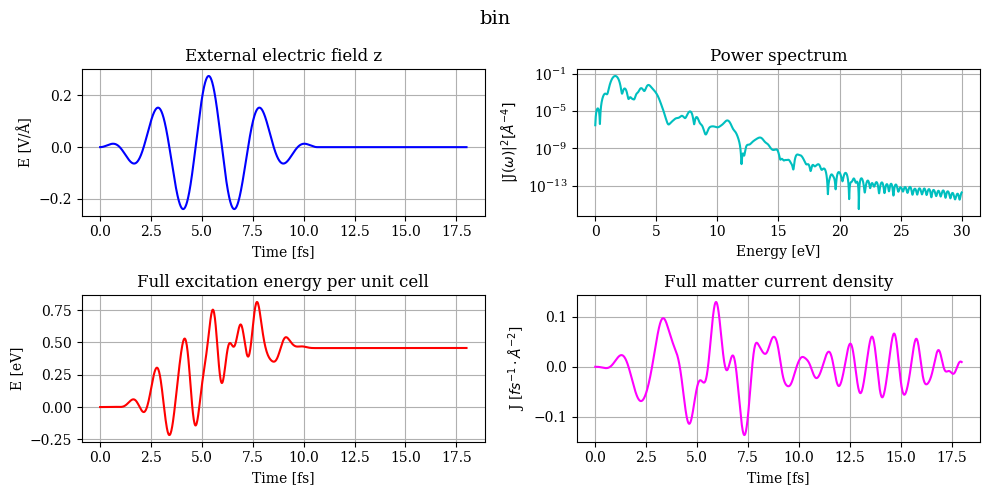

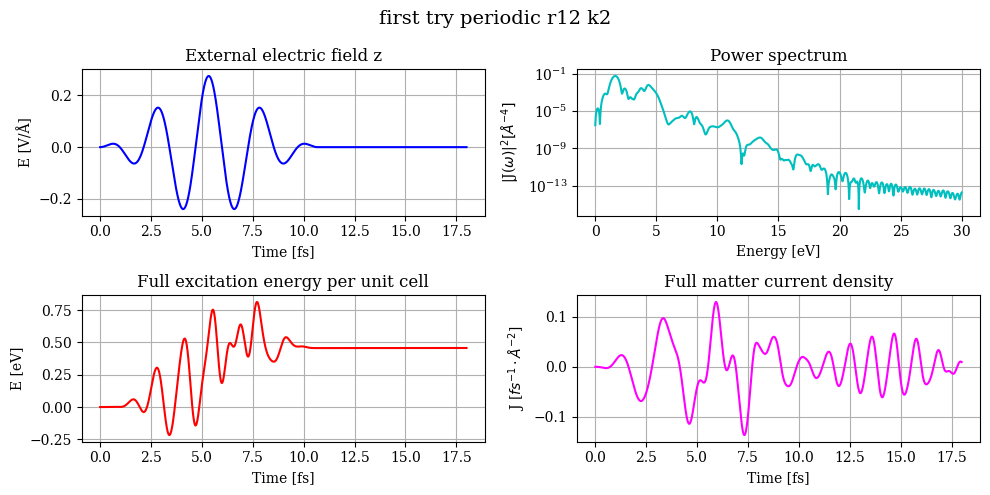

In [119]:
ax = 'z'
E, Jw2_am = plot_response_generated('bin', ax, part_name)
a = plot_response('first_try/periodic/r12_k2', ax)

### Nonlinear plots for generated

In [173]:
def plot_nonlinear_response_generated(folder, ax, part_name):
    
    # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data = pd.read_csv(
        folder + '/Si_' + part_name + '_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    # Назначим читаемые имена колонкам
    data.columns = [
        'time_fs',         # 1
        'Ac_ext_x',        # 2
        'Ac_ext_y',        # 3
        'Ac_ext_z',        # 4
        'E_ext_x',         # 5
        'E_ext_y',         # 6
        'E_ext_z',         # 7
        'Ac_tot_x',        # 8
        'Ac_tot_y',        # 9
        'Ac_tot_z',        #10
        'E_tot_x',         #11
        'E_tot_y',         #12
        'E_tot_z',         #13
        'Jm_x',         #14
        'Jm_y',         #15
        'Jm_z',         #16
    ]
    
    t = data['time_fs']
    Jm = data['Jm_'+ax]
    El_f = data['E_ext_z']
    
    # 1:Time[fs] 2:Ac_ext_x[fs*V/Angstrom] 3:Ac_ext_y[fs*V/Angstrom] 4:Ac_ext_z[fs*V/Angstrom]
    #5:E_ext_x[V/Angstrom] 6:E_ext_y[V/Angstrom] 7:E_ext_z[V/Angstrom] 8:Ac_tot_x[fs*V/Angstrom]
    # 9:Ac_tot_y[fs*V/Angstrom] 10:Ac_tot_z[fs*V/Angstrom] 11:E_tot_x[V/Angstrom]
    # 12:E_tot_y[V/Angstrom] 13:E_tot_z[V/Angstrom]  14:Jm_x[1/fs*Angstrom^2] 15:Jm_y[1/fs*Angstrom^2] 16:Jm_z[1/fs*Angstrom^2]
    
    
    # Построим графики
    plt.figure(figsize=(10, 8.5))

    # Общий заголовок для всей фигуры
    plt.suptitle(' '.join(re.split('[/_]', folder)), fontsize=14)
    
    # Первый график: внешнее поле по z
    plt.subplot(4, 2, 1)
    plt.plot(data['time_fs'], data['E_ext_z'], label='E_ext_z', color='blue')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [V/Å]')
    plt.title('External electric field z')
    plt.grid(True)
    #plt.legend()
    
    # Второй график: дипольный момент по z
    plt.subplot(4, 2, 4)
    plt.plot(data['time_fs'], data['Jm_'+ax], label='Dipole Moment z', color='magenta')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \cdot Å^{-2}$]')
    plt.title('Full matter current density')
    plt.grid(True)
    #plt.legend()
    
    plt.tight_layout()
    
    # Загрузка данных с указанием имен столбцов
    energy_data = pd.read_csv(
        folder + '/Si_' + part_name + '_rt_energy.data',
        comment='#',
        delim_whitespace=True,
        header=None,
        names=['Time_fs', 'E_total_eV', 'Delta_E_eV']
    )
    
    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 3)
    plt.plot(energy_data['Time_fs'], energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='r')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Full excitation energy per unit cell')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    del_E = energy_data['Delta_E_eV']
    
    # Загрузка данных с указанием имен столбцов
    data = pd.read_csv(
        folder + '/Si_' + part_name + '_pulse.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    # Назначим читаемые имена колонкам
    data.columns = [
        'energy_eV',           # 1
        'Re_Jm_x',             # 2
        'Re_Jm_y',             # 3
        'Re_Jm_z',             # 4
        'Im_Jm_x',             # 5
        'Im_Jm_y',             # 6
        'Im_Jm_z',             # 7
        'Abs2_Jm_x',           # 8
        'Abs2_Jm_y',           # 9
        'Abs2_Jm_z',           #10
        'Re_E_ext_x',          #11
        'Re_E_ext_y',          #12
        'Re_E_ext_z',          #13
        'Im_E_ext_x',          #14
        'Im_E_ext_y',          #15
        'Im_E_ext_z',          #16
        'Abs2_E_ext_x',        #17
        'Abs2_E_ext_y',        #18
        'Abs2_E_ext_z',        #19
        'Re_E_tot_x',          #20
        'Re_E_tot_y',          #21
        'Re_E_tot_z',          #22
        'Im_E_tot_x',          #23
        'Im_E_tot_y',          #24
        'Im_E_tot_z',          #25
        'Abs2_E_tot_x',        #26
        'Abs2_E_tot_y',        #27
        'Abs2_E_tot_z',        #28
    ]

    Jw2 = data['Abs2_Jm_'+ax]
    energy = data['energy_eV']
    # Построение графика для 1 и 10 колонки
    plt.subplot(4, 2, 2)
    plt.plot(data['energy_eV'], data['Abs2_Jm_'+ax], label='', color='c')
    plt.xlabel('Energy [eV]')
    plt.ylabel('|J($\omega)|^2 [Å^{-4}]$')
    plt.yscale('log')
    plt.title('Power spectrum')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

        # Загрузка данных, пропуская строки с комментариями (начинаются с #)
    data = pd.read_csv(
        folder + '/Si_weak_' + part_name + '_rt.data',
        comment='#',
        delim_whitespace=True,
        header=None
    )
    
    # Назначим читаемые имена колонкам
    data.columns = [
        'time_fs',         # 1
        'Ac_ext_x',        # 2
        'Ac_ext_y',        # 3
        'Ac_ext_z',        # 4
        'E_ext_x',         # 5
        'E_ext_y',         # 6
        'E_ext_z',         # 7
        'Ac_tot_x',        # 8
        'Ac_tot_y',        # 9
        'Ac_tot_z',        #10
        'E_tot_x',         #11
        'E_tot_y',         #12
        'E_tot_z',         #13
        'Jm_x',         #14
        'Jm_y',         #15
        'Jm_z',         #16
    ]

    J_nonl = Jm - 10**3*data['Jm_'+ax]
    
    plt.subplot(4, 2, 6)
    plt.plot(data['time_fs'], Jm - 10**3*data['Jm_'+ax], label='', color='orange')
    plt.xlabel('Time [fs]')
    plt.ylabel('J [$fs^{-1} \cdot Å^{-2}$]')
    plt.title('Nonlinear matter current density')
    plt.grid(True)


    # Загрузка данных с указанием имен столбцов
    energy_data = pd.read_csv(
        folder + '/Si_weak_' + part_name + '_rt_energy.data',
        comment='#',
        delim_whitespace=True,
        header=None,
        names=['Time_fs', 'E_total_eV', 'Delta_E_eV']
    )
    
    # Построение графика изменения энергии во времени
    plt.subplot(4, 2, 5)
    plt.plot(energy_data['Time_fs'], del_E -10**6*energy_data['Delta_E_eV'], label='ΔE = E_total - E_initial', color='lime')
    plt.xlabel('Time [fs]')
    plt.ylabel('E [eV]')
    plt.title('Nonlinear excitation energy per unit cell')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    

    data = pd.read_csv(
    folder + '/Si_response_' + part_name + '_response.data',
    comment='#',
    delim_whitespace=True,
    header=None
)

    # Назначим читаемые имена колонкам
    data.columns = [
        'Energy_eV',         # 1
        'Re_sigma_x',        # 2
        'Re_sigma_y',        # 3
        'Re_sigma_z',        # 4
        'Im_sigma_x',        # 5
        'Im_sigma_y',        # 6
        'Im_sigma_z',        # 7
        'Re_eps_x',          # 8
        'Re_eps_y',          # 9
        'Re_eps_z',          #10
        'Im_eps_x',          #11
        'Im_eps_y',          #12
        'Im_eps_z',          #13
    ]
    E_resp = data['Energy_eV']
    Im_eps = data['Im_eps_'+ax]
    Re_eps = data['Re_eps_'+ax]

    plt.subplot(4, 2, 7)
    plt.plot(E_resp[100:], Re_eps[100:], label='', color='olive')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Re$[\epsilon(\omega)]$')
    plt.title('Dielectric function')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    plt.subplot(4, 2, 8)
    plt.plot(E_resp[100:], Im_eps[100:], label='', color='black')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Im$[\epsilon(\omega)]$')
    plt.title('Dielectric function')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()

    plt.show()
    

    return t, energy, Jw2, El_f, J_nonl, Jm

### Plots

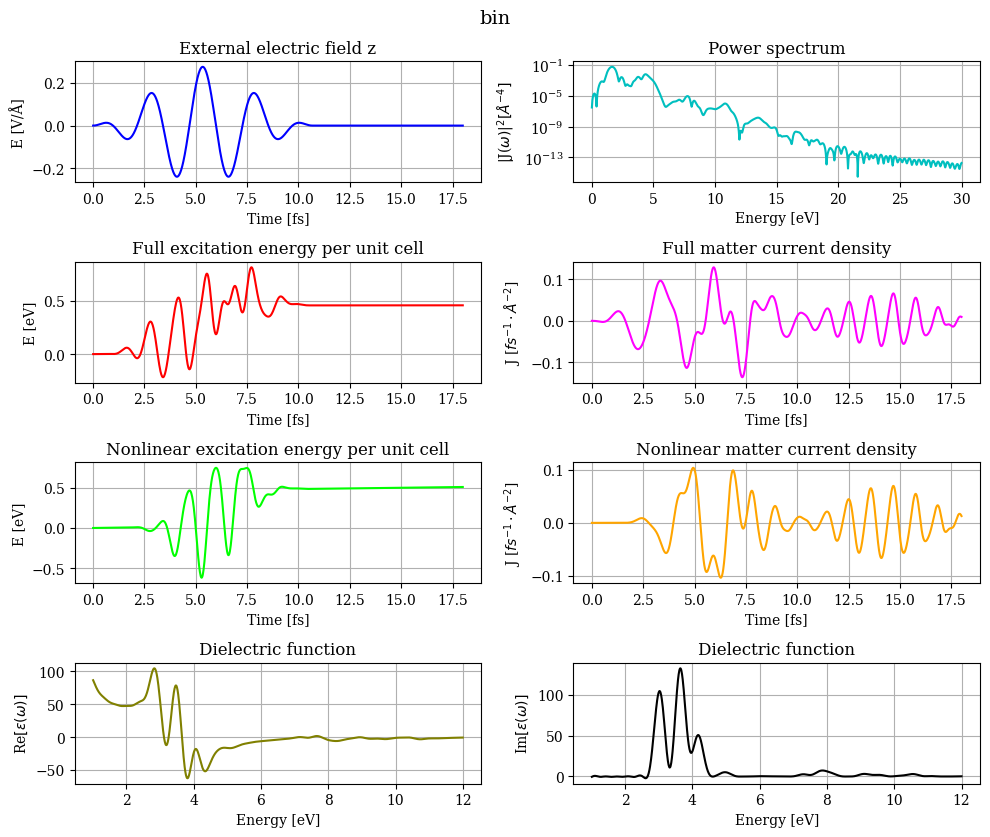

In [174]:
ax = 'z'
a = plot_nonlinear_response_generated('bin', ax, part_name)

### Draft

In [125]:
# НЕ ЗАБЫВАЙ В gs ФАЙЛЕ ИЗМЕНЯТЬ НА ! Index must correspond to   &atomic_reduced_coord (вроде все равно, так как не находит end)

# img1 = mpimg.imread('periodic_Si.png')
# img2 = mpimg.imread('disordered_Si.png')

# fig, axs = plt.subplots(1, 2, figsize=(12, 12))  # 1 строка, 2 столбца

# axs[0].imshow(img1)
# axs[0].axis('off')  # убрать оси
# axs[0].set_title("periodic")

# axs[1].imshow(img2)
# axs[1].axis('off')
# axs[1].set_title("disordered")
# plt.show()

In [174]:
# nx, ny, nz = 1, 1, 1

# # Формируем строки для каждого атома
# atoms_data = []
# for i in range(8):
#     atoms_data.append(f"  'Si'    {x[i]/2:.3f}    {y[i]/2:.3f}    {z[i]:.3f}    1")

# atoms_data.append('')

# for i in range(8):
#     atoms_data.append(f"  'Si'    {x[i]/2 + 0.5:.3f}    {y[i]/2:.3f}    {z[i]:.3f}    1")

# atoms_data.append('')


# # Открываем файл для записи
# with open('atoms_coordinates.txt', 'w') as f:
#     for line in atoms_data:
#         f.write(line + '\n')  # Пишем строку в файл и добавляем новую строку

# print("Координаты атомов сохранены в файл 'atoms_coordinates.txt'  \n")


# # Выводим результат
# for line in atoms_data:
#     print(line)

In [35]:
# nx_max = 3
# ny_max = 1
# nz_max = 2

# atoms_data = []

# for nx, ny, nz in np.ndindex(nx_max, ny_max, nz_max):
#     for i in range(8):
#         atoms_data.append(f"  'Si'    {x[i]/nx_max + nx/nx_max:.3f}    {y[i]/ny_max + ny/ny_max:.3f}    {z[i]/nz_max + nz/nz_max:.3f}    1") 
    
#     atoms_data.append('')

# # Открываем файл для записи
# with open('atoms_coordinates.txt', 'w') as f:
#     for line in atoms_data:
#         f.write(line + '\n')  # Пишем строку в файл и добавляем новую строку

# print("Координаты атомов сохранены в файл 'atoms_coordinates.txt'  \n")

# Выводим результат
# for line in atoms_data:
#     print(line)

In [98]:
# xc = 'TBmBJ'
# cval = 1.04
# "  cval = 1.04\n"

# start_idx = None

# # Ставим правильный потенциал
# if functional == 'TBmBJ':
#     print('yes')
#     for i, line in enumerate(lines):
#         if 'xc =' in line:
#             start_idx = i
#             break

# func_data = [f"  xc = 'TBmBJ'", f"  cval ={1.04:.2f}"]

# lines[start_idx] = [line + '\n' for line in func_data]

In [222]:
# nx_max = 2
# ny_max = 1
# nz_max = 1

# atoms_data = []
    
# for nx, ny, nz in np.ndindex(nx_max, ny_max, nz_max):
#     for i in range(8):
#         atoms_data.append(f"  'Si'    {x[i]/nx_max + nx/nx_max:.3f}    {y[i]/ny_max + ny/ny_max:.3f}    {z[i]/nz_max + nz/nz_max:.3f}    1") 
    
#     atoms_data.append('')


# #Выводим результат
# for line in atoms_data:
#     print(line)

In [271]:
# def create_cell(nx_max, ny_max, nz_max, dev): 
    
#     atoms_data = []
    
#     for nx, ny, nz in np.ndindex(nx_max, ny_max, nz_max):
#         for i in range(8):
            
#             rx, ry, rz = np.clip(np.random.normal(0, dev, 3),-2*dev ,2*dev)
    
#             xval = x[i]/nx_max + nx/nx_max
#             yval = y[i]/ny_max + ny/ny_max
#             zval = z[i]/nz_max + nz/nz_max
            
#             if 0 < xval+rx < 1:
#                 xval+=(rx/nx_max)
#             if 0 < yval+ry < 1:
#                 yval+=(ry/ny_max)
#             if 0 < zval+rz < 1:
#                 zval+=(rz/nz_max)
        
#             atoms_data.append(f"  'Si'    {xval:.3f}    {yval:.3f}    {zval:.3f}    1") 
        
#         atoms_data.append('')
    

#     return atoms_data

In [274]:



# input_type = 'response'

# nx_max = 1
# ny_max = 2
# nz_max = 1

# num_r = 12
# num_k = 2

# a = 1

# num_it  = 1000
# num_thr = 9

# functional = 'PZ'
# # func = 'PZ'

# dev = 0

# atoms_data = create_cell(nx_max, ny_max, nz_max, dev)


# if input_type == 'gs':
#     with open('base_inputs/Si_gs.inp', 'r') as file:
#         lines = file.readlines()


# if input_type == 'pulse' or input_type == 'weak_pulse':
#     with open('base_inputs/Si_rt_pulse.inp', 'r') as file:
#         lines = file.readlines()


# if input_type == 'response':
#     with open('base_inputs/Si_rt_response.inp', 'r') as file:
#         lines = file.readlines()


        
# if input_type == 'gs' or input_type == 'pulse':
#     # Заменяем строку для названия output файлов
#     for i, line in enumerate(lines):
#         if 'sysname' in line:
#             lines[i] = f"  sysname = 'Si_c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}'\n"


# if input_type == 'weak_pulse':
#     # Заменяем строку для названия output файлов
#     for i, line in enumerate(lines):
#         if 'sysname' in line:
#             lines[i] = f"  sysname = 'Si_weak_c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}'\n"

# if input_type == 'response':
#     # Заменяем строку для названия output файлов
#     for i, line in enumerate(lines):
#         if 'sysname' in line:
#             lines[i] = f"  sysname = 'Si_response_c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}'\n"
    

# # Заменяем строку для al(1:3)
# for i, line in enumerate(lines):
#     if 'al(1:3)' in line:
#         lines[i] = f"  al(1:3) = {nx_max*5.43:.2f}d0, {ny_max*5.43:.2f}d0, {nz_max*5.43:.2f}d0\n"

# # Заменяем строку для num_rgrid(1:3)
# for i, line in enumerate(lines):
#     if 'num_rgrid(1:3)' in line:
#         lines[i] = f"  num_rgrid(1:3) = {nx_max*num_r:.0f}, {ny_max*num_r:.0f}, {nz_max*num_r:.0f}\n"

# # Заменяем строку для num_kgrid(1:3)
# for i, line in enumerate(lines):
#     if 'num_kgrid(1:3)' in line:
#         lines[i] = f"  num_kgrid(1:3) = {num_k/nx_max:.0f}, {num_k/ny_max:.0f}, {num_k/nz_max:.0f}\n"


# start_idx = None
# end_idx = None

# # Находим места начала и конца для замены количества атомов и электронов
# for i, line in enumerate(lines):
#     if 'nelem  =' in line:
#         start_idx = i
#     if '/' in line and start_idx is not None:
#         end_idx = i
#         break


# n_data = [f"  natom  = {8*nx_max*ny_max*nz_max:.0f}", f"  nelec  = {32*nx_max*ny_max*nz_max:.0f}", f"  nstate = {a*32*nx_max*ny_max*nz_max:.0f}"]

# # Заменяем блок координат
# lines[start_idx + 1:end_idx] = [line + '\n' for line in n_data]


# # Заменяем старые координаты атомов новыми
# start_idx = None
# end_idx = None

# # Находим места начала и конца для замены атомных координат
# for i, line in enumerate(lines):
#     if '&atomic_red_coor' in line:
#         start_idx = i
#     if '!--- Format' in line and start_idx is not None:
#         end_idx = i
#         break

# # Заменяем блок координат
# lines[start_idx + 1:end_idx] = [line + '\n' for line in atoms_data]


# if input_type == 'weak_pulse':
#     # Заменяем мощность
#     for i, line in enumerate(lines):
#         if 'I_wcm2_1 =' in line:
#             lines[i] = "  I_wcm2_1 = 1.0d6\n"


# if input_type == 'gs':
#     # Заменяем строку для nscf
#     for i, line in enumerate(lines):
#         if 'nscf' in line:
#             lines[i] = f"  nscf      = {num_it:.0f}\n"
    
#     # Заменяем строку для threshold
#     for i, line in enumerate(lines):
#         if 'threshold =' in line:
#             lines[i] = f"  threshold = 1.0d-{num_thr:.0f}\n"

# fold_name = f"  c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}"

# if input_type == 'gs':
#     os.mkdir("generated/"+fold_name)

# if input_type == 'gs':
#     # Сохраняем изменения в файл
#     with open("generated/" + fold_name + f"/Si_gs_c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
#         file.writelines(lines)

# if input_type == 'pulse':
#     # Сохраняем изменения в файл
#     with open("generated/" + fold_name + f"/Si_rt_pulse_c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
#         file.writelines(lines)

# if input_type == 'weak_pulse':
#     # Сохраняем изменения в файл
#     with open("generated/" + fold_name + f"/Si_weak_rt_pulse_c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
#         file.writelines(lines)

# if input_type == 'response':
#     # Сохраняем изменения в файл
#     with open("generated/" + fold_name + f"/Si_response_rt_pulse_c{nx_max}{ny_max}{nz_max}_s0_r{num_r}_k{num_k}_a{a}_i{num_it}_t{num_thr}.inp", 'w') as file:
#         file.writelines(lines)

In [41]:
# input_type = 'response'

# nx_max = 1
# ny_max = 2
# nz_max = 1

# num_r = 12
# num_k = 2

# a = 1

# num_it  = 1000
# num_thr = 9

# # functional = 'PZ'
# # func = 'PZ'

# dev = 0

In [1]:
    # # Заменяем functional
    # for i, line in enumerate(lines):
    #     if 'al(1:3)' in line:
    #         lines[i] = f"  al(1:3) = {nx_max*5.43:.2f}d0, {ny_max*5.43:.2f}d0, {nz_max*5.43:.2f}d0\n"